# Fitting with time delay scan
## Objective
1. Fitting with exponential decay model
2. Save and Load fitting result
3. Calculates species associated coefficent from fitting result
4. Evaluates F-test based confidence interval


In this example, we only deal with gaussian irf 

In [1]:
# import needed module
import numpy as np
import matplotlib.pyplot as plt
import TRXASprefitpack
from TRXASprefitpack import solve_seq_model, rate_eq_conv 
plt.rcParams["figure.figsize"] = (12,9)

## Version information

In [2]:
print(TRXASprefitpack.__version__)

0.7.0


## Fitting with exponential decay model

In [3]:
# Generates fake experiment data
# Model: 1 -> 2 -> GS
# lifetime tau1: 500 ps, tau2: 10 ns
# fwhm paramter of gaussian IRF: 100 ps

tau_1 = 500
tau_2 = 10000
fwhm = 100

# initial condition
y0 = np.array([1, 0, 0])

# set time range (mixed step)
t_seq1 = np.arange(-2500, -500, 100)
t_seq2 = np.arange(-500, 1500, 50)
t_seq3 = np.arange(1500, 5000, 250)
t_seq4 = np.arange(5000, 50000, 2500)

t_seq = np.hstack((t_seq1, t_seq2, t_seq3, t_seq4))

eigval_seq, V_seq, c_seq = solve_seq_model(np.array([tau_1, tau_2]), y0)

# Now generates measured transient signal
# Last element is ground state

abs_1 = [1, 1, 0]
abs_2 = [0.5, 0.8, 0]
abs_3 = [-0.5, 0.7, 0]
abs_4 = [0.6, 0.3, 0]

t0 = np.random.normal(0, fwhm, 4) # perturb time zero of each scan

# generate measured data

y_obs_1 = rate_eq_conv(t_seq-t0[0], fwhm, abs_1, eigval_seq, V_seq, c_seq, irf='g')
y_obs_2 = rate_eq_conv(t_seq-t0[1], fwhm, abs_2, eigval_seq, V_seq, c_seq, irf='g')
y_obs_3 = rate_eq_conv(t_seq-t0[2], fwhm, abs_3, eigval_seq, V_seq, c_seq, irf='g')
y_obs_4 = rate_eq_conv(t_seq-t0[3], fwhm, abs_4, eigval_seq, V_seq, c_seq, irf='g')

# generate random noise with (S/N = 20)

# Define noise level (S/N=20) w.r.t peak
eps_obs_1 = np.max(np.abs(y_obs_1))/20*np.ones_like(y_obs_1)
eps_obs_2 = np.max(np.abs(y_obs_2))/20*np.ones_like(y_obs_2)
eps_obs_3 = np.max(np.abs(y_obs_3))/20*np.ones_like(y_obs_3)
eps_obs_4 = np.max(np.abs(y_obs_4))/20*np.ones_like(y_obs_4)

# generate random noise
noise_1 = np.random.normal(0, eps_obs_1, t_seq.size)
noise_2 = np.random.normal(0, eps_obs_2, t_seq.size)
noise_3 = np.random.normal(0, eps_obs_3, t_seq.size)
noise_4 = np.random.normal(0, eps_obs_4, t_seq.size)


# generate measured intensity
i_obs_1 = y_obs_1 + noise_1
i_obs_2 = y_obs_2 + noise_2
i_obs_3 = y_obs_3 + noise_3
i_obs_4 = y_obs_4 + noise_4

# print real values

print('-'*24)
print(f'fwhm: {fwhm}')
print(f'tau_1: {tau_1}')
print(f'tau_2: {tau_2}')
for i in range(4):
    print(f't_0_{i+1}: {t0[i]}')
print('-'*24)
print('Excited Species contribution')
print(f'scan 1: {abs_1[0]} \t {abs_1[1]}')
print(f'scan 2: {abs_2[0]} \t {abs_2[1]}')
print(f'scan 3: {abs_3[0]} \t {abs_3[1]}')
print(f'scan 4: {abs_4[0]} \t {abs_4[1]}')

param_exact = [fwhm, t0[0], t0[1], t0[2], t0[3], tau_1, tau_2]

------------------------
fwhm: 100
tau_1: 500
tau_2: 10000
t_0_1: -156.12041304890062
t_0_2: 38.61083766738686
t_0_3: -70.46010438461614
t_0_4: 96.11767660754525
------------------------
Excited Species contribution
scan 1: 1 	 1
scan 2: 0.5 	 0.8
scan 3: -0.5 	 0.7
scan 4: 0.6 	 0.3


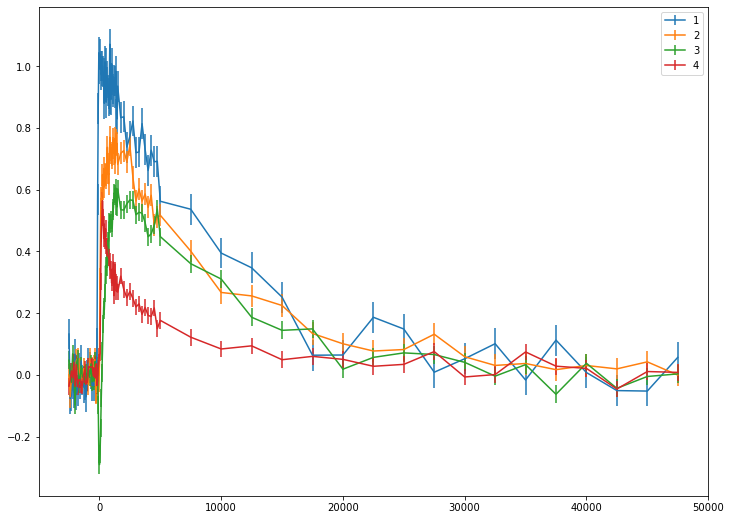

In [4]:
# plot model experimental data

plt.errorbar(t_seq, i_obs_1, eps_obs_1, label='1')
plt.errorbar(t_seq, i_obs_2, eps_obs_2, label='2')
plt.errorbar(t_seq, i_obs_3, eps_obs_3, label='3')
plt.errorbar(t_seq, i_obs_4, eps_obs_4, label='4')
plt.legend()
plt.show()

In [5]:
# import needed module for fitting
from TRXASprefitpack import fit_transient_exp

# time, intensity, eps should be sequence of numpy.ndarray
t = [t_seq] 
intensity = [np.vstack((i_obs_1, i_obs_2, i_obs_3, i_obs_4)).T]
eps = [np.vstack((eps_obs_1, eps_obs_2, eps_obs_3, eps_obs_4)).T]

# set initial guess
irf = 'g' # shape of irf function
fwhm_init = 100
t0_init = np.array([0, 0, 0, 0])
# test with one decay module
tau_init = np.array([15000])

# use global optimization method: AMPGO
fit_result_decay_1 = fit_transient_exp(irf, fwhm_init, t0_init, tau_init, False, 
method_glb='ampgo', t=t, intensity=intensity, eps=eps)


In [6]:
# print fitting result
print(fit_result_decay_1)

[Model information]
    model : decay
    irf: g
    fwhm:  144.4151
    eta:  0.0000
    base: False
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 769
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: `ftol` termination condition is satisfied.
 
[Optimization Results]
    Total Data points: 368
    Number of effective parameters: 10
    Degree of Freedom: 358
    Chi squared:  2180.6363
    Reduced chi squared:  6.0912
    AIC (Akaike Information Criterion statistic):  674.7784
    BIC (Bayesian Information Criterion statistic):  713.8592
 
[Parameters]
    fwhm_G:  144.41507069 +/-  23.65709134 ( 16.38%)
    t_0_1_1: -152.23580141 +/-  12.88603562 ( 8.46%)
    t_0_1_2:  76.21013523 +/-  12.57882417 ( 16.51%)
    t_0_1_3:  200.00000000 +/-  14.64366187 ( 7.32%)
    t_0_1_4:  62.15838170 +/-  18.81500401 ( 30.27%)
    tau_1:  12175.91776145 +/-  742.50080195 ( 6.10%)
 
[Parameter Bound

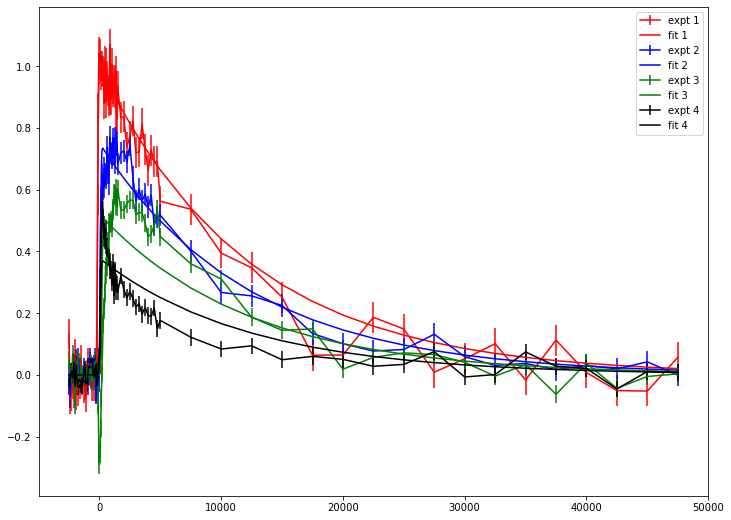

In [7]:
# plot fitting result and experimental data

color_lst = ['red', 'blue', 'green', 'black']

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_decay_1['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.show()

For scan 1 and 2, experimental data and fitting data match well. However for scan 3 and 4, they do not match at shorter time region (< 10000).

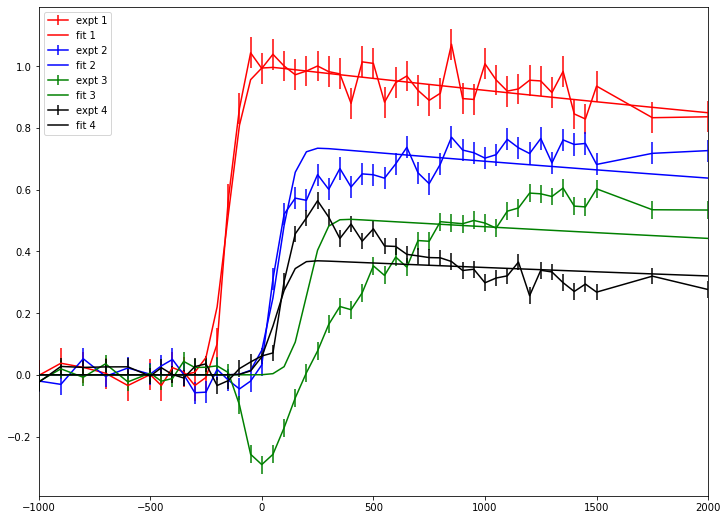

In [8]:
# plot with shorter time range

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_decay_1['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.xlim(-10*fwhm_init, 20*fwhm_init)
plt.show()


There may exists shorter lifetime component.

In [9]:
# try with double exponential decay
# set initial guess
from tabnanny import verbose


irf = 'g' # shape of irf function
fwhm_init = 100
t0_init = np.array([0, 0, 0, 0])
# test with two decay module
tau_init = np.array([300, 15000])

fit_result_decay_2 = fit_transient_exp(irf, fwhm_init, t0_init, tau_init, False, 
method_glb='ampgo', kwargs_lsq={'verbose' : 2}, t=t, intensity=intensity, eps=eps)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8288e+02                                    1.13e-03    
       1              2         1.8288e+02      7.13e-11       2.25e-03       3.89e-05    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 1.8288e+02, final cost 1.8288e+02, first-order optimality 3.89e-05.


In [10]:
# print fitting result
print(fit_result_decay_2)

[Model information]
    model : decay
    irf: g
    fwhm:  101.5631
    eta:  0.0000
    base: False
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 965
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: `ftol` termination condition is satisfied.
 
[Optimization Results]
    Total Data points: 368
    Number of effective parameters: 15
    Degree of Freedom: 353
    Chi squared:  365.7519
    Reduced chi squared:  1.0361
    AIC (Akaike Information Criterion statistic):  27.745
    BIC (Bayesian Information Criterion statistic):  86.3663
 
[Parameters]
    fwhm_G:  101.56312034 +/-  8.65279856 ( 8.52%)
    t_0_1_1: -153.31713009 +/-  4.86051817 ( 3.17%)
    t_0_1_2:  43.99363705 +/-  6.94025884 ( 15.78%)
    t_0_1_3: -67.50417257 +/-  6.36057697 ( 9.42%)
    t_0_1_4:  101.54236607 +/-  4.39923343 ( 4.33%)
    tau_1:  497.19877854 +/-  19.08450237 ( 3.84%)
    tau_2:  9901.14794048 +/-  2

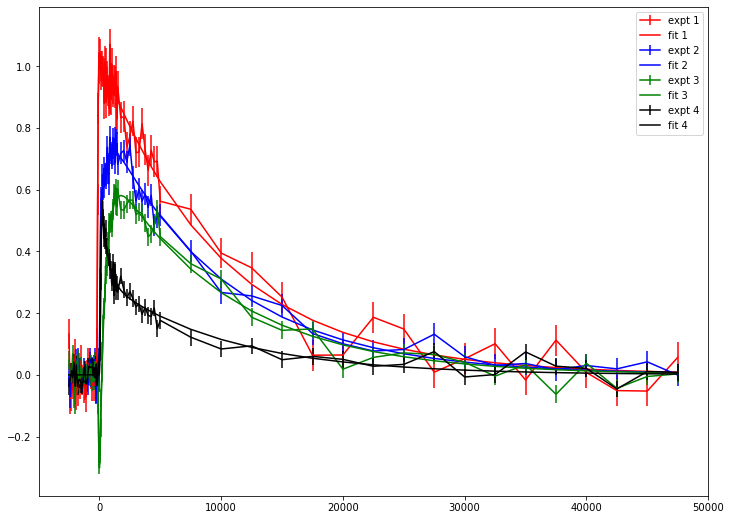

In [11]:
# plot fitting result and experimental data

color_lst = ['red', 'blue', 'green', 'black']

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_decay_2['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.show()



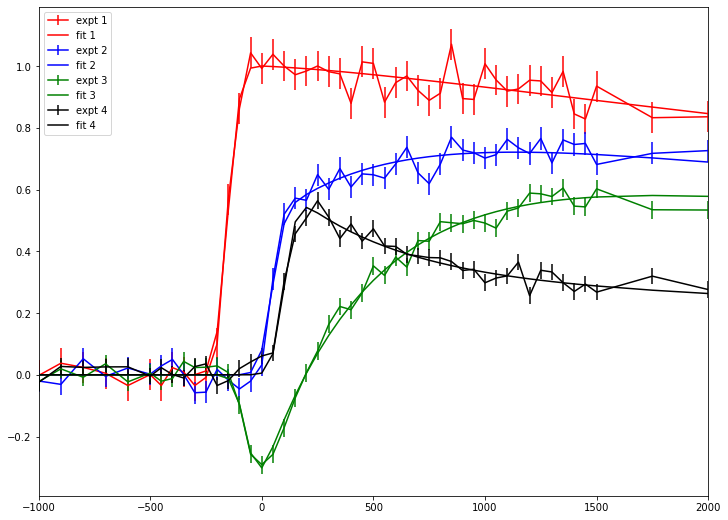

In [12]:
# plot with shorter time range

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_decay_2['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.xlim(-10*fwhm_init, 20*fwhm_init)
plt.show()

Two decay model fits well

In [13]:
# Compare fitting value and exact value
for i in range(len(fit_result_decay_2['x'])):
    print(f"{fit_result_decay_2['param_name'][i]}: {fit_result_decay_2['x'][i]} (fit) \t {param_exact[i]} (exact)")

fwhm_G: 101.563120337142 (fit) 	 100 (exact)
t_0_1_1: -153.31713008689923 (fit) 	 -156.12041304890062 (exact)
t_0_1_2: 43.9936370546416 (fit) 	 38.61083766738686 (exact)
t_0_1_3: -67.50417256681469 (fit) 	 -70.46010438461614 (exact)
t_0_1_4: 101.54236606639758 (fit) 	 96.11767660754525 (exact)
tau_1: 497.1987785448846 (fit) 	 500 (exact)
tau_2: 9901.14794048022 (fit) 	 10000 (exact)


Fitting result and exact result are match well.
For future use or transfer your fitting result to your collaborator or superviser, you want to save or load fitting result from file.

In [14]:
# save fitting result to file
from TRXASprefitpack import save_TransientResult, load_TransientResult

save_TransientResult(fit_result_decay_2, 'example_decay_2') # save fitting result to example_decay_2.h5
loaded_result = load_TransientResult('example_decay_2') # load fitting result from example_decay_2.h5

Now deduce species associated difference coefficient from sequential decay model

In [15]:
y0 = np.array([1, 0, 0]) # initial cond
eigval, V, c = solve_seq_model(loaded_result['x'][5:], y0)

# compute scaled V matrix
V_scale = np.einsum('j,ij->ij', c, V)
diff_abs_fit = np.linalg.solve(V_scale[:-1, :-1].T, loaded_result['c'][0]) # slice last column and row corresponding to ground state

# compare with exact result
print('-'*24)
print('[Species Associated Difference Coefficent]')
print('scan # \t ex 1 (fit) \t ex 1 (exact) \t ex 2 (fit) \t ex 2 (exact)')
print(f'1 \t {diff_abs_fit[0,0]} \t {abs_1[0]}  \t {diff_abs_fit[1,0]} \t {abs_1[1]}')
print(f'2 \t {diff_abs_fit[0,1]} \t {abs_2[0]}  \t {diff_abs_fit[1,1]} \t {abs_2[1]}')
print(f'3 \t {diff_abs_fit[0,2]} \t {abs_3[0]}  \t {diff_abs_fit[1,2]} \t {abs_3[1]}')
print(f'4 \t {diff_abs_fit[0,3]} \t {abs_4[0]}  \t {diff_abs_fit[1,3]} \t {abs_4[1]}')


------------------------
[Species Associated Difference Coefficent]
scan # 	 ex 1 (fit) 	 ex 1 (exact) 	 ex 2 (fit) 	 ex 2 (exact)
1 	 1.0037847366325658 	 1  	 0.9995440788449074 	 1
2 	 0.5064294402029949 	 0.5  	 0.805300497592594 	 0.8
3 	 -0.4772831402102139 	 -0.5  	 0.6988293554639244 	 0.7
4 	 0.6038784961845008 	 0.6  	 0.29551241800998834 	 0.3


It also matches well, as expected.

The error of paramter reported from `Transient` Driver is based on Asymptotic Standard Error.
However, strictly, ASE cannot be used in non-linear regression.
TRXASprefitpack provides alternative error estimation based on `F-test`.

In [16]:
from TRXASprefitpack import confidence_interval

ci_result = confidence_interval(loaded_result, 0.05) # set significant level: 0.05 -> 95% confidence level
print(ci_result) # report confidence interval

[Report for Confidence Interval]
    Method: f
    Significance level:  5.000000e-02
 
[Confidence interval]
    101.56312034 -  17.18281259 <= fwhm_G <=  101.56312034 +  18.07428539
    -153.31713009 -  9.49174207 <= t_0_1_1 <= -153.31713009 +  9.44520352
    43.99363705 -  12.62990633 <= t_0_1_2 <=  43.99363705 +  12.24103969
    -67.50417257 -  12.37327962 <= t_0_1_3 <= -67.50417257 +  12.61249769
    101.54236607 -  9.33060371 <= t_0_1_4 <=  101.54236607 +  9.37813454
    497.19877854 -  37.12480863 <= tau_1 <=  497.19877854 +  39.7229684
    9901.14794048 -  551.12555403 <= tau_2 <=  9901.14794048 +  573.87599666


In [17]:
# compare with ase
from scipy.stats import norm

factor = norm.ppf(1-0.05/2)

print('[Confidence interval (from ASE)]')
for i in range(loaded_result['param_name'].size):
    print(f"{loaded_result['x'][i] :.8f} - {factor*loaded_result['x_eps'][i] :.8f}", 
          f"<= {loaded_result['param_name'][i]} <=", f"{loaded_result['x'][i] :.8f} + {factor*loaded_result['x_eps'][i] :.8f}")

[Confidence interval (from ASE)]
101.56312034 - 16.95917355 <= fwhm_G <= 101.56312034 + 16.95917355
-153.31713009 - 9.52644056 <= t_0_1_1 <= -153.31713009 + 9.52644056
43.99363705 - 13.60265737 <= t_0_1_2 <= 43.99363705 + 13.60265737
-67.50417257 - 12.46650178 <= t_0_1_3 <= -67.50417257 + 12.46650178
101.54236607 - 8.62233908 <= t_0_1_4 <= 101.54236607 + 8.62233908
497.19877854 - 37.40493731 <= tau_1 <= 497.19877854 + 37.40493731
9901.14794048 - 557.94642507 <= tau_2 <= 9901.14794048 + 557.94642507


However, as you can see, in many case, ASE does not much different from more sophisticated `f-test` based error estimation.